<img src="light-bulb.png" alt="Flowers in Chania" style="float:left;width:100px;height:100px;">
<center><h1 style="color:#B40404;">Electric Power Generation prediction in Canada</h1></center>

<h5 style="color:#585858;">Author: Vannia Hnatiuk</h5>
<h5 style="color:#585858;">Date: April 4<sup>th</sup>, 2022</h5>

<h2><a style="color:#943126;font-weight:bold" id='one'>ARIMA</a></h2>



[1. Introduction](#one)<br>
    [1.1 Reading the data](#one-one)<br>
    [1.2 System Representation](#one-two)<br>
[2. Modeling](#two)<br>
    [2.1 ARIMA on seasonal difference](#two-one)<br>
        [2.1.1 Augmented Dickey Fuller Test](#two-one-one)<br>
        [2.1.2 Autocorrelation Function](#two-one-two)<br>
        [2.1.3 Partial Autocorrelation Function](#two-one-three)<br>
        [2.1.4 Modeling](#two-one-four)<br>
        [2.1.5 Reconstruction of the system](#two-one-five)<br>
        [2.1.6 Model Evaluation](#two-one-six)<br>
    [2.2 ARIMA on original data](#two-two)<br>
        [2.2.1 Autocorrelation Function](#two-two-one)<br>
        [2.2.2 Partial Autocorrelation function](#two-two-two)<br>
        [2.2.3 Modeling](#two-two-three)<br>
        [2.2.4 Model Evaluation](#two-two-four)<br>
    [2.3 Grid Search Autoarima](#two-three)<br>
        [2.3.1 Grid Search](#two-three-one)<br>
        [2.3.2 Modeling](#two-three-two)<br>
        [2.3.3 Model Evaluation](#two-two-three)<br>
    [2.4 ARIMA on logarithmic transformed data](#two-four)<br>
        [2.4.1 Autocorrelation Function](#two-four-one)<br>
        [2.4.2 Partial Autocorrelation Function](#two-four-two)<br>
        [2.4.3 Augmented Dickey Fuller test and KPSS test](#two-four-three)<br>
        [2.4.4 Modeling](#two-four-four)<br>
        [2.4.5 Model Evaluation](#two-four-five)<br>
[3. Conclusions](#three)<br>
[4. References](#four)<br>

Importing the necessary library to perform the analysis

In [1]:
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#sklearn
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

#ARIMA gridsearch
import pmdarima as pm

#new pandas index
from pandas import Int64Index as NumericIndex

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/var/folders/rf/tbzlwmhn4t3_np15yjldzz200000gn/T/ipykernel_35641/2092345554.py:26: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(20,10)

<h3 style="color:#943126" id='one-one'>Reading the data</h3>

This dataset was extracted from the <a style="color:#F08080;font-size:115%;" href='01_EDA.ipynb'>EDA Notebook</a> which has the required features: the dates and the dependant variable. The time frame covers from January 1950' to December 2007'. The variable of interest is <span style="color:#4267B2;font-weight:bold"> VALUE</span> which quantifies the electric power generated in millions of Megawatts-Hour.

In [3]:
df=pd.read_csv('data/can_50_08.csv',parse_dates=['REF_DATE'],index_col='REF_DATE')
df.head()


,VALUE
REF_DATE,
1950-01-01,4081000.0
1950-02-01,3780000.0
1950-03-01,4186000.0
1950-04-01,4070000.0
1950-05-01,4425000.0


In [4]:
df.tail()

,VALUE
REF_DATE,
2007-08-01,48161855.0
2007-09-01,42731316.0
2007-10-01,46575984.0
2007-11-01,51217155.0
2007-12-01,57338168.0


In [5]:
canada=df.copy()

In [6]:
canada.head()

,VALUE
REF_DATE,
1950-01-01,4081000.0
1950-02-01,3780000.0
1950-03-01,4186000.0
1950-04-01,4070000.0
1950-05-01,4425000.0


Renaming the variable of study 'VALUE' to 'POWER'.

In [7]:
canada.rename(columns = {'VALUE':'POWER'}, inplace = True)

<h3 style="color:#943126" id='one-two'>System Representation</h3>

Although, this plot was previously analysed in the EDA Notebook, it is being kept in order to have a reminder of the characteristic of the time series. 

In [8]:
# add lines for each column
fig = px.line(canada, x=canada.index, y=canada['POWER'], template='ggplot2')

# axis labels and title
fig.update_layout(
    yaxis_title="Millions of Megawatt-hour", 
    xaxis_title="Decades",
    legend_title="Power", 
    title="Power Generation over time",
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

<center><h2><a style="color:#943126" id='two'>Modeling </h2></center>

<h3><a style="color:#943126" id='two-one'><u>ARIMA model on seasonal difference on a yearly basis</u></h3>

Applying differentiation of 12 lags (1 year behind)

In [9]:
#Yearly seasonal difference
canada["seasonal_difference"] = canada["POWER"].diff(12)

In [10]:
fig = px.line(canada, x=canada.index, y="seasonal_difference",template='ggplot2')

fig.update_layout(
    yaxis_title="Difference Megawattshour", 
    xaxis_title="Date",
    title="Seasonal Difference on yearly basis",
    plot_bgcolor='#F0ECEC'
)

fig.show()

The seasonal Difference showed an expanded variance: however, the mean lands at 0 at the seasonal difference

<h4 id='two-one-one'> Augmented Dickey Fuller Test</h4>

In [11]:
sm.tsa.stattools.kpss(canada['seasonal_difference'].dropna(), regression='ct', nlags='auto', store=False)

(0.19714449609740148,
 0.017070813963474443,
 15,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

Because the <span style="color:#943126"> p-value </span> is  <span style="color:#943126">0.017</span>. Since this value is less than .05, we are able to reject the null hypothesis of the KPSS test. For this reason, the time series trend is <span style="color:#943126;font-weight:bold">not stationary</span>.

In [12]:
canada['seasonal_difference']

REF_DATE
1950-01-01          NaN
1950-02-01          NaN
1950-03-01          NaN
1950-04-01          NaN
1950-05-01          NaN
                ...    
2007-08-01     408886.0
2007-09-01    1003422.0
2007-10-01    1159018.0
2007-11-01    3775622.0
2007-12-01    2763734.0
Name: seasonal_difference, Length: 696, dtype: float64

<h4 style="color:#943126" id='two-one-two'>Splitting the dataset</h4>

The training dataset will be divided in years previous to 2000 whereas the test dataset will cover 7 years later.

In [13]:
train = canada.loc[canada.index <= "1999-12-01", "seasonal_difference"].dropna() #2005-12-01
test = canada.loc[canada.index > "1999-12-01", "seasonal_difference"]#2005-12-01

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', line_color='#A6857A', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines',line_color='#F8766D', name="Test"))
fig.update_layout(
    yaxis_title="Difference Megawatt hour", 
    xaxis_title="Date",
    title="Change in Megawatt hour over Prior Year",
    title_x=0.5
)
fig.update_layout(plot_bgcolor='#F0ECEC')
fig.show()

Looking for autocorrelation for <span style="color:#943126;font-size:110%;font-weight:bold"> 12</span> lags.

In [15]:
fig = px.scatter(
    x=canada["POWER"], 
    y=canada["POWER"].shift(12), # 12-month lagged observations, season
    template='ggplot2')
fig.update_layout(
    xaxis_title="Electricity generation on Current Year", 
    yaxis_title="Electricity Year Lagged"
)
fig.update_layout(plot_bgcolor='#F0ECEC')
fig.show()

This scatter shows a high correlation between the <span style="color:#943126;font-weight:bold">x<sub>t</sub></span> and the lagged <span style="color:#943126;font-weight:bold"> x<sub>t-12</sub>

<h4 style="color:#943126" id='two-one-two'> Autocorrelation Function</h4>

Autocorrelation Function and Partial Correlation Function are auxiliar to configure ARIMA models. The autocorrelation function helps to set parameter q (where a lag repeats seasonality).

<blockquote>Importantly, the order of differencing should not be too great. In general, the value of each parameter of an ARIMA(p, d, q) model should be kept as small as possible to avoid unwarranted complexity and overfitting to the sample data. As a not-at-all-universal rule of thumb, you should be quite skeptical of values of d over 2 and values of p and q over 5 or so. Also, you should expect either the p or q term to dominate and the other to be relatively small. These are practitioner notes gathered from analysts and not hard-and-fast mathematical truths.</blockquote>

Nielsen, Aileen.<i>Practical Time Series Analysis</i>, O'Reilly Media, Inc, October 2019

Autocorrelation in <span style="color:#943126;font-size:100%;font-weight:bold">seasonal difference</span>.

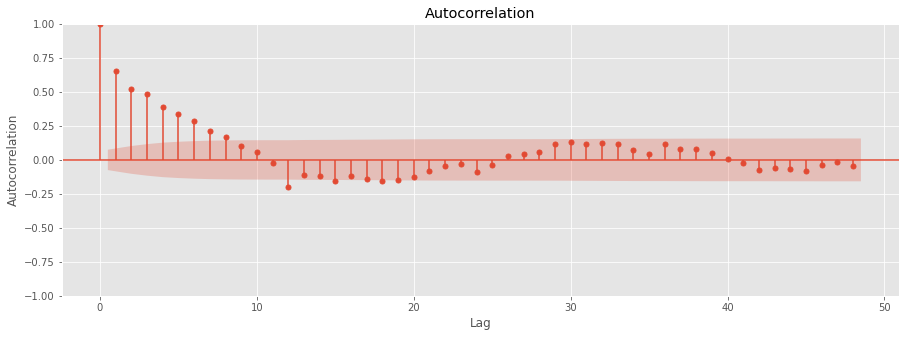

In [16]:
plt.figure(figsize=(15, 5))
plot_acf(canada["seasonal_difference"].dropna(), lags=48, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The plot from the autocorrelation function shows <span style="color:#943126;font-size:110%;font-weight:bold"> 8 </span> significant lags to set parameter <i style="color:#943126;font-size:110%;font-weight:bold"> q </i> to the SARIMAX model.

<h4 style="color:#943126" id='two-one-three'>Partial Autocorrelation</h4>

<p>In this case the partial correlation indicates which lags start fading and in this case we can determine parameter <b>p</b></p>

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



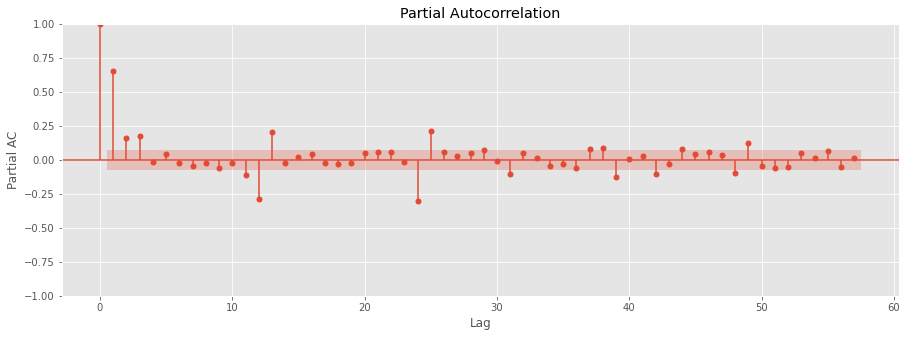

In [17]:
plt.figure(figsize=(15, 5))
plot_pacf(canada["seasonal_difference"].dropna(), lags=57, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

The plot from the partial autocorrelation function shows <span style="color:#943126;font-size:110%;font-weight:bold">15</span> significant lags to set parameter <i style="color:#943126;font-size:110%;font-weight:bold"> p </i> to the SARIMAX model.

<h4><a style="color:#943126" id='two-two-three'><u>ARIMAX model</a></u></h4>

<p>This model used the parameters given by the plots of the autocorrelation function and the partial correlation function. Parameter <b>d </b>was obtained through an automated function from the EDA notebook.</p>

In [18]:
#There is no seasonal component in this model
model_dif = SARIMAX(train, order=(15, 1, 8), trend="ct")
model_dif = model_dif.fit(disp=False)

model_dif.summary()

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     seasonal_difference   No. Observations:                  588
Model:               SARIMAX(15, 1, 8)   Log Likelihood               -8776.817
Date:                 Sat, 02 Apr 2022   AIC                          17605.633
Time:                         17:28:13   BIC                          17719.384
Sample:                     01-01-1951   HQIC                         17649.957
                          - 12-01-1999                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3194.0969   2.03e+04      0.158      0.875   -3.65e+04    4.29e+04
drift          9.6694     61.856      0.156      0.876    -111.566     130.905
ar.L1         -0.2874      0.141     -2.038      0.042      -0.564      -0.011
ar.L2         -0.4485      0.132     -3.407      0.001      -0.707      -0.191
ar.L3         -0.6129      0.096     -6.395      0.000      -0.801      -0.425
ar.L4         -0.1287      0.087     -1.475      0.140      -0.300       0.042
ar.L5         -0.0072      0.071     -0.101      0.920      -0.147       0.133
ar.L6          0.3843      0.065      5.877      0.000       0.256       0.513
ar.L7          0.1772      0.097      1.825      0.068      -0.013       0.368
ar.L8          0.3187      0.087      3.672      0.000       0.149       0.489
ar.L9          0.2157      0.058      3.745      0.000       0.103       0.329
ar.L10         0.1883      0.062      3.045      0.002       0.067       0.310
ar.L11         0.0589      0.059      0.995      0.320      -0.057       0.175
ar.L12        -0.3060      0.054     -5.709      0.000      -0.411      -0.201
ar.L13         0.0559      0.060      0.931      0.352      -0.062       0.174
ar.L14        -0.1920      0.058     -3.339      0.001      -0.305      -0.079
ar.L15        -0.3008      0.063     -4.745      0.000      -0.425      -0.177
ma.L1         -0.1312      0.143     -0.920      0.357      -0.411       0.148
ma.L2          0.2127      0.164      1.294      0.196      -0.109       0.535
ma.L3          0.3079      0.099      3.098      0.002       0.113       0.503
ma.L4         -0.3228      0.072     -4.471      0.000      -0.464      -0.181
ma.L5         -0.0711      0.080     -0.884      0.377      -0.229       0.087
ma.L6         -0.6001      0.079     -7.564      0.000      -0.756      -0.445
ma.L7         -0.1010      0.136     -0.744      0.457      -0.367       0.165
ma.L8         -0.1828      0.125     -1.457      0.145      -0.429       0.063
sigma2      6.056e+11   7.74e-06   7.82e+16      0.000    6.06e+11    6.06e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               526.60
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              24.53   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.24e+35. Standard errors may be unstable.
"""

<h5>1st prediction</h5>

In [19]:
predictions_dif = model_dif.predict(start=0, end=len(train)+len(test)-1)

In [20]:
predictions_dif.tail()

2007-08-01    1.433416e+06
2007-09-01    1.443183e+06
2007-10-01    1.466110e+06
2007-11-01    1.444592e+06
2007-12-01    1.463124e+06
Freq: MS, Name: predicted_mean, dtype: float64

In [21]:
predictions_dif.index.min()

Timestamp('1951-01-01 00:00:00', freq='MS')

In [22]:
predictions_dif.index.max()

Timestamp('2007-12-01 00:00:00', freq='MS')

In [23]:
my_forecast_dif=model_dif.forecast(steps=36)
my_forecast_dif.tail()

2002-08-01    1.166567e+06
2002-09-01    9.839949e+05
2002-10-01    1.196245e+06
2002-11-01    1.395594e+06
2002-12-01    9.801625e+05
Freq: MS, Name: predicted_mean, dtype: float64

Joining the predictions with the forecast

In [24]:
whole_prediction_dif=pd.concat([predictions_dif,my_forecast_dif['2008-02-01':]],ignore_index=False)

In [25]:
whole_prediction_dif

1951-01-01    1.699938e+03
1951-02-01    4.847208e+05
1951-03-01    5.070296e+05
1951-04-01    6.225339e+05
1951-05-01    6.256506e+05
                  ...     
2007-08-01    1.433416e+06
2007-09-01    1.443183e+06
2007-10-01    1.466110e+06
2007-11-01    1.444592e+06
2007-12-01    1.463124e+06
Freq: MS, Name: predicted_mean, Length: 684, dtype: float64

Training dataset using the <span style="color:#B40404;font-size:100%;font-weight:bold">seasonal difference</span>

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', line_color='#619CFF', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test,line_color='#F8766D', mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=whole_prediction_dif.index, y=whole_prediction_dif, mode='lines', line_color='#515A5A',
                        opacity=0.7, name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Millions of Megawatt-hour", 
    xaxis_title="Decades",
    title="Forecast performed on Seasonal Difference",
    title_x=0.5
)
fig.update_layout(plot_bgcolor='#F0ECEC')
fig.show()

Characterizing the ARIMAX model, the prediction attempeted to follow the original time series and degraded fluctuations, and starts to attenuate towards the average of the system. For this reason, it needs more tunning for parameters q and p for better results. Moreover, it failed to predict the high peak of difference in electricity generation.

<h4 style="color:#943126;font-weight:bold" id='two-one-five' >Reconstruction of Original signal</h4>

Because this model was fitted with seasonal differenced data 12 lags back, the plot looks very different to the original system. How it should like the original series? In order to see the plot with the same shape as the original, it is necessary to integrate back the difference between <span style="color:#943126;font-weight:bold">x<sub>t</sub></span> and the lagged <span style="color:#943126;font-weight:bold"> x<sub>t-12</sub>.

In [27]:
first_date = canada.index.min()

# create an empty restored column
canada["restored"] = np.nan

# fill in the first 12 original values from VALUE
canada.loc[first_date: first_date + pd.DateOffset(months=11), "restored"] = \
    canada.loc[first_date: first_date + pd.DateOffset(months=11), "POWER"]

# use the current difference and 12-month lagged restored value to get the next restored
#restored = seasonal difference + restored
for date, val in canada.loc[first_date + pd.DateOffset(months=12):, "seasonal_difference"].items():
    canada.loc[date, "restored"] = canada.loc[date - pd.DateOffset(months=12), "restored"] + val

# check agreement everywhere (rounding errors can come up so check closeness rather than strict equality)
np.allclose(canada["POWER"], canada["restored"])

True

In [28]:
# use the original train diff values and predicted test values
canada.loc[train.index, "difference"] = canada.loc[train.index, "seasonal_difference"]
canada.loc[test.index, "difference"] = predictions_dif[test.index]

# empty restored column
canada["signal_restored"] = np.nan

# fill in the first 12 original values
canada.loc[first_date: first_date + pd.DateOffset(months=11), "signal_restored"] = \
    canada.loc[first_date: first_date + pd.DateOffset(months=11), "POWER"]

# use the current difference and 12-month lagged restored value to get the next restored
for date, val in canada.loc[first_date + pd.DateOffset(months=12):, "difference"].items():
    canada.loc[date, "signal_restored"] = \
        canada.loc[date - pd.DateOffset(months=12), "signal_restored"] + val

In [29]:
canada.head(14)

,POWER,seasonal_difference,restored,difference,signal_restored
REF_DATE,,,,,
1950-01-01,4081000.0,NaN,4081000.0,NaN,4081000.0
1950-02-01,3780000.0,NaN,3780000.0,NaN,3780000.0
1950-03-01,4186000.0,NaN,4186000.0,NaN,4186000.0
1950-04-01,4070000.0,NaN,4070000.0,NaN,4070000.0
1950-05-01,4425000.0,NaN,4425000.0,NaN,4425000.0
1950-06-01,4313000.0,NaN,4313000.0,NaN,4313000.0
1950-07-01,4201000.0,NaN,4201000.0,NaN,4201000.0
1950-08-01,4199000.0,NaN,4199000.0,NaN,4199000.0
1950-09-01,4121000.0,NaN,4121000.0,NaN,4121000.0


In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=canada.loc[train.index, "POWER"], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=canada.loc[test.index, "POWER"], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=test.index, y=canada.loc[test.index, "signal_restored"], 
                                line_color='#A6857A', mode='lines', name="prediction"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Electicity generated in Millions of Megawatts", 
    xaxis_title="Decades",
    title="Electricity Comparisson Real vs Reconstruction",
    title_x=0.5,
    plot_bgcolor='#F0ECEC'
)
fig.show()

The reconstructed signal could emulate the original data and part of the forecast up to the first 11 months.Conversely, since the predicted June 2001 the prediction start to drift upwards and the variance began to shrink.

<h4 style="color:#943126" id='two-one-six'>Model Evaluation</h4>

In [31]:

train_mape = 100*mean_absolute_percentage_error(train, predictions_dif[train.index])
test_mape = 100*mean_absolute_percentage_error(test, predictions_dif[test.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 230.4%
Test MAPE on the difference: 309.42%


In [32]:

train_MAE = mean_absolute_error(train, predictions_dif[train.index])
test_MAE = mean_absolute_error(test, predictions_dif[test.index])

print(f"Train MAE on the difference: {train_MAE:,.2f}")
print(f"Test MAE on the difference: {test_MAE:,.2f}")

Train MAE on the difference: 500,859.94
Test MAE on the difference: 1,781,417.75


<p>Either the Mean Absolute Error and Mean Percentage Error shows a big margin between the forecast and the original data. This leads to look to other methods for predictions that can get closer to the real values.</p>

<h3><a style="color:#943126" id='two-two'><u>ARIMA model on original data</a></u></h3>

The training dataset will be divided in years previous to 2000 whereas the test dataset will cover 7 years later without seasonal difference. 

In [33]:
train2=canada.loc[:'1999','POWER']
train2.tail()

REF_DATE
1999-08-01    45447279.0
1999-09-01    43987478.0
1999-10-01    46451327.0
1999-11-01    47267093.0
1999-12-01    53140049.0
Name: POWER, dtype: float64

In [34]:
test2=canada.loc['2000':,'POWER']
test2.head()

REF_DATE
2000-01-01    57271638.0
2000-02-01    52266866.0
2000-03-01    50535074.0
2000-04-01    45641566.0
2000-05-01    45489843.0
Name: POWER, dtype: float64

<h4 style="color:#B40404;" id='two-two-one'> Autocorrelation Function</h4>

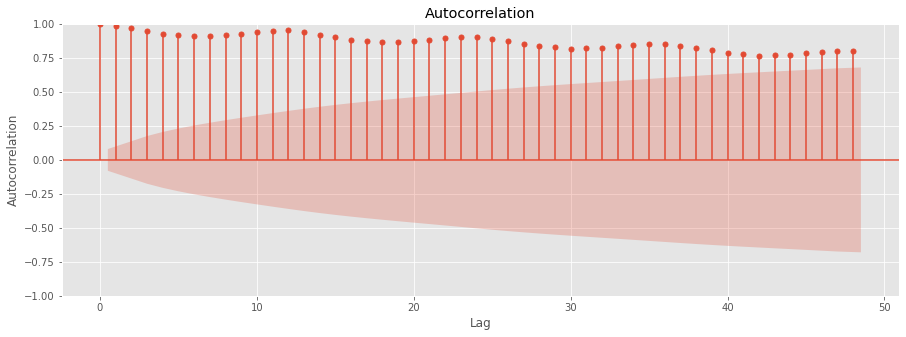

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(train2, lags=48, ax=plt.gca()) #lags=58
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The autocorrelation function points ideally to <span style="color:#943126;font-size:110%;font-weight:bold">11 </span> cycles <i style="color:#943126;font-size:110%;font-weight:bold"> q </i> to the ARIMAX model.

<h4 style="color:#943126" id='two-two-three'>Partial Autocorrelation</h4>

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



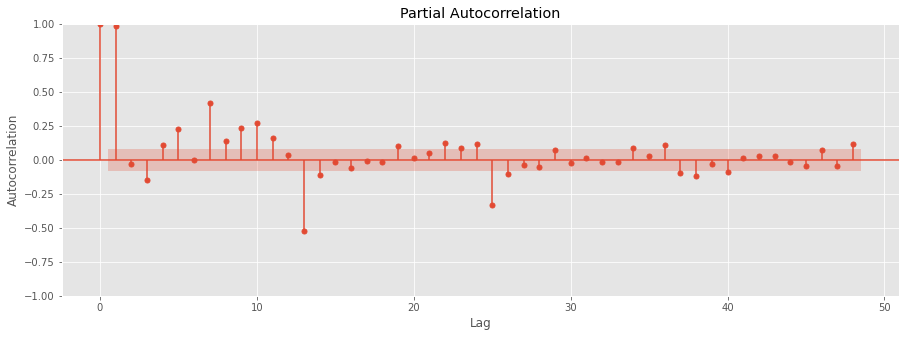

In [36]:

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_pacf(train2, lags=48, ax=plt.gca()) #lags 58
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The partial autocorrelation function indicates <span style="color:#943126;font-size:110%;font-weight:bold">12</span> most significant lags  to set parameter <i style="color:#943126;font-size:110%;font-weight:bold"> p </i> to the ARIMAX model.

<h4 style="color:#943126" id='two-two-three'> Modeling</h4>

In [37]:
p_param = 12    #given the partial correlation function
d_param = 1     # one differencing step
q_param = 6     # half the parameter p or q, because only ones need to be predominant than the other

model_1 = SARIMAX(train2, order=(p_param, d_param, q_param), trend="ct")
model_1 = model_1.fit(disp=False)

model_1.summary()

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  POWER   No. Observations:                  600
Model:              SARIMAX(12, 1, 6)   Log Likelihood               -9025.429
Date:                Sat, 02 Apr 2022   AIC                          18092.858
Time:                        17:28:17   BIC                          18185.159
Sample:                    01-01-1950   HQIC                         18128.792
                         - 12-01-1999                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.569e+05      0.174   9.01e+05      0.000    1.57e+05    1.57e+05
drift        140.7197    109.328      1.287      0.198     -73.559     354.998
ar.L1         -0.1666      0.053     -3.165      0.002      -0.270      -0.063
ar.L2         -0.1921      0.048     -4.012      0.000      -0.286      -0.098
ar.L3         -0.2617      0.047     -5.575      0.000      -0.354      -0.170
ar.L4         -0.2091      0.049     -4.237      0.000      -0.306      -0.112
ar.L5         -0.1820      0.046     -3.937      0.000      -0.273      -0.091
ar.L6         -0.3029      0.048     -6.308      0.000      -0.397      -0.209
ar.L7         -0.2007      0.048     -4.161      0.000      -0.295      -0.106
ar.L8         -0.2178      0.044     -4.972      0.000      -0.304      -0.132
ar.L9         -0.2412      0.047     -5.154      0.000      -0.333      -0.149
ar.L10        -0.1859      0.050     -3.752      0.000      -0.283      -0.089
ar.L11        -0.1727      0.042     -4.124      0.000      -0.255      -0.091
ar.L12         0.6348      0.042     14.961      0.000       0.552       0.718
ma.L1         -0.3056      0.059     -5.165      0.000      -0.422      -0.190
ma.L2          0.0012      0.046      0.026      0.979      -0.089       0.091
ma.L3          0.0197      0.046      0.432      0.666      -0.070       0.109
ma.L4         -0.0539      0.054     -1.005      0.315      -0.159       0.051
ma.L5          0.1575      0.049      3.219      0.001       0.062       0.253
ma.L6          0.1419      0.050      2.852      0.004       0.044       0.239
sigma2      7.022e+11   2.96e-08   2.37e+19      0.000    7.02e+11    7.02e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               352.84
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              11.52   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.98e+33. Standard errors may be unstable.
"""

In [38]:
predictions_1 = model_1.predict(start=0, end=len(train2)+len(test2)-1)

<h4 style="color:#943126" id='two-two-four'>Model Evaluation</h4>

In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train2.index, y=train2, mode='lines',opacity=0.75, name="Train"))
fig.add_trace(go.Scatter(x=test2.index, y=test2, mode='lines',line_color='#F8766D', opacity=0.75,name="Test"))
fig.add_trace(go.Scatter(x=predictions_1.index, y=predictions_1, mode='lines',
                        line_color='#A6857A', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Megawatts of Power Generated ", 
    xaxis_title="Decades",
    title="Original Data and ARIMA Comparison",
    title_x=0.5
)
fig.update_layout(plot_bgcolor='#F0ECEC')
fig.show()

The forecast caught fairly the pattern from the past decades. Then, it start elevating in parallel to the test data since April 2001 and the line couldn't keep the original characterization of the time series. The final prediction is 60.588 M of mwh where the original data got 57.338 M of mwh, this means <span style="color:#943126">3.25 M mwh upper</span>.

<h4> Residual Analysis</h4>

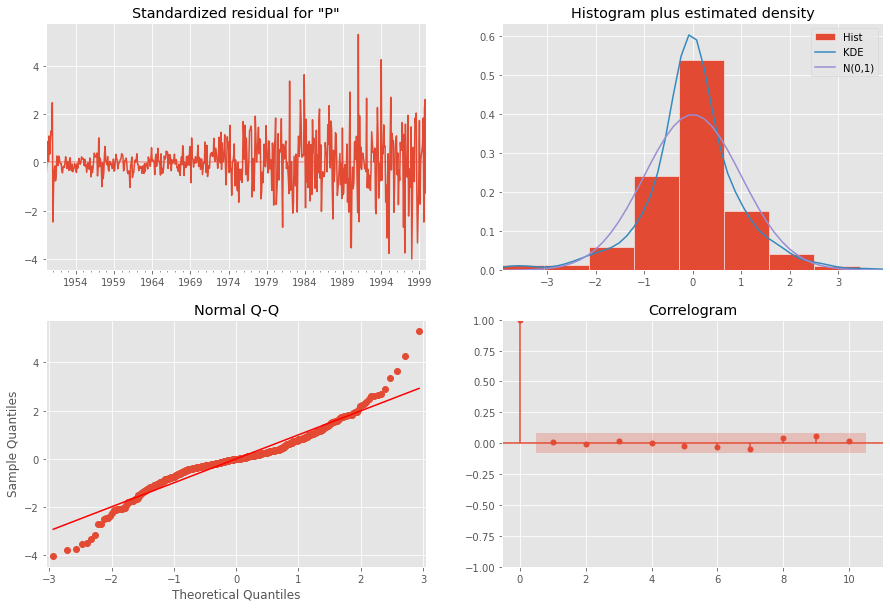

In [40]:
model_1.plot_diagnostics(figsize=(15,10))
plt.show()

Based on the residuals plots:
<ul>
<li><b>Standardized residual for parameter:</b>the residuals presented a fluctuation at the beginning, then it reduced and finally increased variance ("heteroscedascity").</li>
<li><b>Histogram and estimated density:</b>the residuals are normally distributed with a very slight positive skeweness.</li>
<li><b>Q-Qplot:</b>Despite the plot tries to stick to the trend line, it looks a little bit twisted and skewness at the extremes. It seems that the residuals are not entirely normally distributed.</li>
<li><b>Correlogram:</b>Apart of the first lag, all data points stays at 0 in the X-axis.</li>
</ul>
Most of the plots shows that the ARIMA in original data performed good, but the Q-Q plot shows that it's worthy to tune a better model. 

Now,it is an opportunity to perform an assesment through the Mean Absolute Error and Mean Percentage Error.

In [41]:
predictions_1 = model_1.predict(start=0, end=len(train2)+len(test2)-1)

train_mape_1 = 100*mean_absolute_percentage_error(train2, predictions_1[train2.index])
test_mape_1 = 100*mean_absolute_percentage_error(test2, predictions_1[test2.index])

print(f"Train MAPE on ARIMA: {round(train_mape_1, 2)}%")
print(f"Test MAPE on ARIMA: {round(test_mape_1, 2)}%")

Train MAPE on ARIMA: 3.11%
Test MAPE on ARIMA: 8.43%


In [42]:
train_MAE_1 = mean_absolute_error(train2, predictions_1[train2.index])
test_MAE_1 = mean_absolute_error(test2, predictions_1[test2.index])

print(f"Train MAE on ARIMA: {train_MAE_1:,.2f}")
print(f"Test MAE on ARIMA: {test_MAE_1:,.2f}")

Train MAE on ARIMA: 579,057.65
Test MAE on ARIMA: 3,912,764.13


The Test Mean Absolute Percentage error is  <span style="color:#943126;font-weight:bold">5.32%</span> greater than the training MAPE. In magnitude, the training was <span style="color:#943126;font-weight:bold"> 579 K</span> Megawatt hour from the real generation in that time period, while the test was <span style="color:#943126;font-weight:bold"> 3.9 M </span> of Megawatt hour from the real data. According to these metrics, the model look overfit.

<h3 style="color:#943126" id='two-three'>Auto-Arima: Grid Search Parameter</h3>

The autocorrelation function and partial autocorrelation functions are an initial tools to determine parameters p and q. However, sometimes their interpretation can be limited and their quantities should be small in order to avoid complexities and extended processing times. In order to achieve an accurate model, it was performed a grid search through the autoarima model from pmdarima. Auto-ARIMA works by conducting differencing tests (i.e., KPSS, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D. This automated model selection selects the best model with the lowest <span style="color:#943126"> AIC (Akaike information criterion) </span> metric. Where the lowest value determines the best model. This metric helps to avoid overfitting because it penalize models with lots of parameter and high d, D's. 

In [43]:
import pmdarima as pm

# Create auto_arima model
model2 = pm.auto_arima(train2, #time series
                    seasonal=True, # is the time series seasonal
                    m=12, # the seasonal period - one year
                    d=1, # non-seasonal difference order
                    D=1, # seasonal difference order
                    max_p=5, # max value of p to test 
                    max_q=5, # max value of p to test
                    max_P=5, # max value of P to test 
                    max_Q=5, # max value of Q to test 
                    information_criterion='aic', # used to select best mode
                    trace=True, # prints the information_criterion for each model it fits
                    error_action='ignore', # ignore orders that don't work
                    stepwise=True, # apply an intelligent order search
                    suppress_warnings=True,
                    n_jobs=-2) 

# Print model summary
print(model2.summary())


Performing stepwise search to minimize aic


/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



 ARIMA(2,1,2)(1,1,1)[12]             : AIC=17616.852, Time=8.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=17846.553, Time=0.35 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=17687.417, Time=3.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=17632.097, Time=3.33 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=17614.856, Time=7.39 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=17616.851, Time=69.11 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=17653.482, Time=6.70 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=17616.562, Time=116.24 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=17613.465, Time=5.05 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=17615.461, Time=6.61 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=17615.461, Time=48.72 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=17651.909, Time=4.80 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=17615.176, Ti

<h4 style="color:#943126;font-weight:bold" id='two-three-one'>Modeling </h4>

The grid search indicated the best parameters to model the SARIMAX. It is time to see how this model performs with these parameters.

In [44]:
p_param = 1 
d_param = 1   
q_param = 2

P_param= 0
D_param= 1
Q_param= 1
S_param= 12

model_seasonal = SARIMAX(train2, order=(p_param, d_param, q_param), seasonal_order=(P_param, D_param, Q_param, S_param), trend="ct")
model_seasonal = model_seasonal.fit(disp=True) #adding verbosity 

model_seasonal.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46845D+01    |proj g|=  9.00834D-02


/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.



At iterate    1    f=  1.46788D+01    |proj g|=  1.24499D-02

At iterate    2    f=  1.46786D+01    |proj g|=  8.89908D-03

At iterate    3    f=  1.46783D+01    |proj g|=  4.27476D-03

At iterate    4    f=  1.46782D+01    |proj g|=  5.10778D-03

At iterate    5    f=  1.46772D+01    |proj g|=  2.26597D-02

At iterate    6    f=  1.46765D+01    |proj g|=  2.05924D-02

At iterate    7    f=  1.46764D+01    |proj g|=  1.89016D-02

At iterate    8    f=  1.46760D+01    |proj g|=  3.13471D-03

At iterate    9    f=  1.46759D+01    |proj g|=  2.10112D-03

At iterate   10    f=  1.46759D+01    |proj g|=  2.82519D-04

At iterate   11    f=  1.46759D+01    |proj g|=  2.23538D-04

At iterate   12    f=  1.46759D+01    |proj g|=  2.23346D-04

At iterate   13    f=  1.46759D+01    |proj g|=  5.70634D-04

At iterate   14    f=  1.46759D+01    |proj g|=  1.16946D-03

At iterate   15    f=  1.46759D+01    |proj g|=  2.19788D-03

At iterate   16    f=  1.46759D+01    |proj g|=  3.82425D-03

At iter

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                POWER   No. Observations:                  600
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -8802.038
Date:                              Sat, 02 Apr 2022   AIC                          17618.076
Time:                                      17:34:50   BIC                          17648.701
Sample:                                  01-01-1950   HQIC                         17630.009
                                       - 12-01-1999                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6598.6713   1.24e+04     -0.531      0.595    -3.1e+04    1.78e+04
drift         16.3464     28.194      0.580      0.562     -38.912      71.605
ar.L1          0.5596      0.138      4.043      0.000       0.288       0.831
ma.L1         -0.8945      0.143     -6.266      0.000      -1.174      -0.615
ma.L2          0.0514      0.082      0.627      0.530      -0.109       0.212
ma.S.L12      -0.5648      0.031    -18.200      0.000      -0.626      -0.504
sigma2      7.911e+11      0.000   1.63e+15      0.000    7.91e+11    7.91e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               535.33
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              18.00   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.81e+31. Standard errors may be unstable.
"""

In [45]:
predictions_seasonal = model_seasonal.predict(start=0, end=len(train2)+len(test2)-1)

In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train2.index, y=train2, mode='lines',opacity=0.75, name="Train"))
fig.add_trace(go.Scatter(x=test2.index, y=test2, mode='lines',line_color='#F8766D', opacity=0.75,name="Test"))
fig.add_trace(go.Scatter(x=predictions_seasonal.index, y=predictions_seasonal, mode='lines',
                        line_color='#A6857A', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Megawatts of Power Generated ", 
    xaxis_title="Decades",
    title="Original Data and Prediction With Seasonal Component",
    title_x=0.5
)
fig.update_layout(plot_bgcolor='#F0ECEC')
fig.show()

Again this optimal model could capture the pattern of the training data and only 11 months in the test dataset, then it started to float over the test trend. Still, it could preserved the original waveform like the original data and the last prediction pointed <span style="color:#943126;font-weight:bold"> 6.17 M of megawatts  </span> higher  than the last observation in the test dataset.

<h4 style="color:#943126" id='two-three-three'>Model Evaluation</h4>

In [47]:
predictions_seasonal = model_seasonal.predict(start=0, end=len(train2)+len(test2)-1)

train_mape_seasonal = 100*mean_absolute_percentage_error(train2, predictions_seasonal[train2.index])
test_mape_seasonal = 100*mean_absolute_percentage_error(test2, predictions_seasonal[test2.index])

print(f"Train MAPE on SARIMAX: {round(train_mape_seasonal, 2)}%")
print(f"Test MAPE on SARIMAX: {round(test_mape_seasonal, 2)}%")

Train MAPE on SARIMAX: 2.62%
Test MAPE on SARIMAX: 8.13%


In [48]:
train_MAE_seasonal = mean_absolute_error(train2, predictions_seasonal[train2.index])
test_MAE_seasonal = mean_absolute_error(test2, predictions_seasonal[test2.index])

print(f"Train MAE on SARIMAX: {train_MAE_seasonal:,.2f}")
print(f"Test MAE on SARIMAX: {test_MAE_seasonal:,.2f}")

Train MAE on SARIMAX: 520,863.91
Test MAE on SARIMAX: 3,839,244.97


The Evaluation metrics MAE and MAPE reduced modestly. The MAPE in the test data only improved <span style="color:#943126;font-weight:bold">0.4% </span> where the MAE cut down only <span style="color:#943126;font-weight:bold"> 70 K </span> of mwh , in comparison to the previous model. So far, these models can not make long term predictions. 

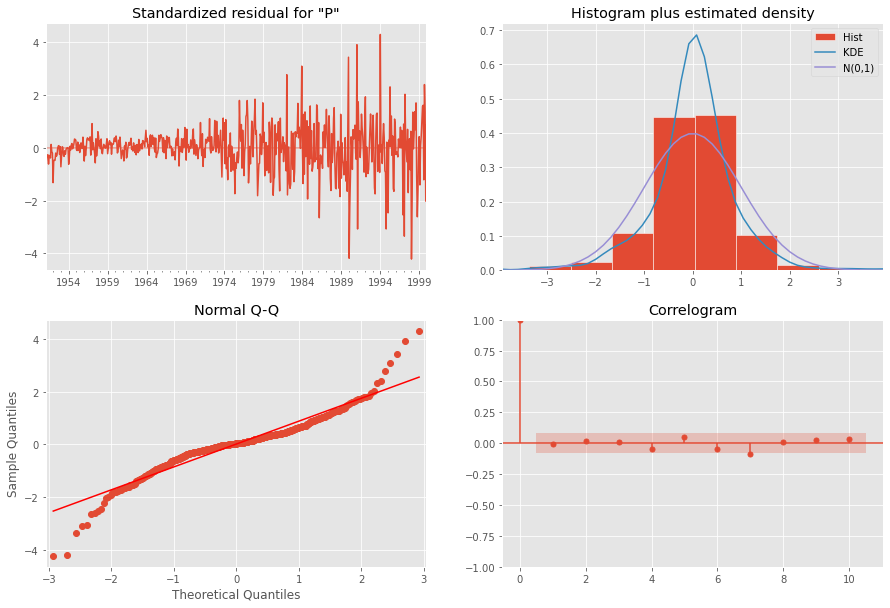

In [49]:

model_seasonal.plot_diagnostics(figsize=(15,10))
plt.show()

Based on the residuals plots:
<ul>
<li><b>Standardized residual for parameter:</b>these residuals showed an increased heteroscedascity in 1990 and later years </li>
<li><b>Histogram and estimated density:</b>the residuals are normally distributed with a very slight positive skeweness .</li>
<li><b>Q-Qplot:</b>The plot is a little more straight in comparisson with the past model and same skewness at the tails. This shape would stay the same because of the size of the data</li>
<li><b>Correlogram:</b>Apart of the first lag, none of the values cross the significance threshold. Hence, they don't look self correlated. </li>
</ul>
Most of the plots shows that the ARIMA with seasonal decomposition of the original data performed best than past ARIMA models.

<h3><a style="color:#943126" id='two-four'><u>ARIMA on Log Transformed Data</a></u></h3>

Applying Logarithmic transformation to train and test data

In [50]:
train_log=np.log10(canada.loc[:'2000','POWER'])
test_log=np.log10(canada.loc['2000':,'POWER'])

<h4 style="color:#943126" id='two-four-one'> Autocorrelation Function</h4>

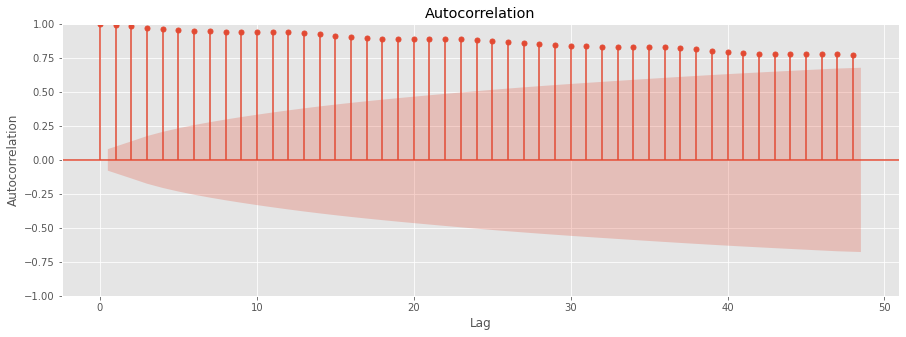

In [51]:
plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(train_log, lags=48, ax=plt.gca()) #lags=58
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Because the time series were logaritmic transformed, the cyclicity smoothed significantly.

<h4 style="color:#943126" id='two-four-two'>Partial Autocorrelation</h4>

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



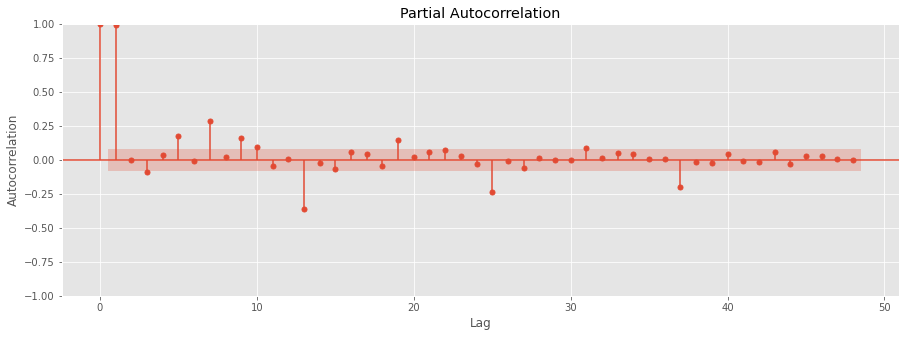

In [52]:
plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_pacf(train_log, lags=48, ax=plt.gca()) #lags 58
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Partial Autocorrelation function shows 1 significant lag.

<h4 style="color:#943126" id='two-four-three'> Augmented Dickey-Fuller test</h4>

In [53]:
adf, pvalue, critical, results = sm.tsa.stattools.adfuller(train_log, regresults=True)

In [54]:
print(pvalue)

0.050065797750822844


Based on the results from adf, the p-value in this log transformed time series is small enough to discard the null hypothesis that suggest that there is a source of non stationarity. As a result, this series <span style="color:#943126;">is stationary</span>.

<h4 style="color:#943126">KPSS Test </h4>

In [55]:
sm.tsa.stattools.kpss(train_log, regression='ct', nlags='auto', store=False)

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1998: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(0.9083138192123089,
 0.01,
 15,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

However, the pvalue returned from the KPSS rejects the null hypothesis that sustains that is stationary. As a result, this trend is <span style="color:#943126;">not stationary</span>.

<h4 style="color:#943126" id='two-four-four'>Modeling</h4>

In [56]:
p_param = 1 
d_param = 1   
q_param = 0      

model_log = SARIMAX(train_log, order=(p_param, d_param, q_param), trend="ct")
model_log = model_log.fit(disp=False)

model_log.summary()

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  POWER   No. Observations:                  612
Model:               SARIMAX(1, 1, 0)   Log Likelihood                1291.837
Date:                Sat, 02 Apr 2022   AIC                          -2575.673
Time:                        17:34:52   BIC                          -2558.013
Sample:                    01-01-1950   HQIC                         -2568.804
                         - 12-01-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0032      0.003      1.155      0.248      -0.002       0.009
drift      -4.138e-06   7.15e-06     -0.578      0.563   -1.82e-05    9.88e-06
ar.L1         -0.0118      0.048     -0.248      0.804      -0.105       0.082
sigma2         0.0009   5.88e-05     14.491      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.75
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
predictions_log = model_log.predict(start=0, end=len(train2)+len(test2)-1)

In [58]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_log.index, y=train_log, mode='lines', opacity=0.75, name="Train"))
fig.add_trace(go.Scatter(x=test_log.index, y=test_log, mode='lines',
                            line_color='#F8766D', opacity=0.75, name="Test"))
fig.add_trace(go.Scatter(x=predictions_log.index, y=predictions_log, 
                            mode='lines',line_color='#A6857A', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Millions of MWH", 
    xaxis_title="Decade",
    title="Prediction on Logarithmic transformed Data",
    title_x=0.5
)
fig.update_layout(plot_bgcolor='#F0ECEC')
fig.show()

In this plot it is perceived the shape of the transformed time series at logarithmic scale.

Transforming back the logarithmic train, test, prediction and forecast subsets to the original values. This is done to applying the inverse function, where 10 is elevated to the transformed values. 

In [60]:
train_back=10**train_log
test_back=10**test_log
predictions_back=10**predictions_log

Checking if the inversion returned the same values as the original data.

In [61]:
train_back.head()

REF_DATE
1950-01-01    4081000.0
1950-02-01    3780000.0
1950-03-01    4186000.0
1950-04-01    4070000.0
1950-05-01    4425000.0
Name: POWER, dtype: float64

<h4 style="color:#943126" id='two-four-five'>Model Evaluation</h4>

Calculating the Mean Percentage Error and the Mean Absolute Error

In [62]:
train_back_mape = 100*mean_absolute_percentage_error(train_back, predictions_back[train_log.index])
test_back_mape = 100*mean_absolute_percentage_error(test_back, predictions_back[test_log.index])

print(f"Train MAPE on the difference: {round(train_back_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_back_mape, 2)}%")

Train MAPE on the difference: 5.69%
Test MAPE on the difference: 20.4%


In [63]:
train_back_mae = mean_absolute_error(train_back, predictions_back[train_log.index])
test_back_mae = mean_absolute_error(test_back, predictions_back[test_log.index])

print(f"Train MAE on the difference: {train_back_mae:,.2f}")
print(f"Test MAE on the difference: {test_back_mae:,.2f}")

Train MAE on the difference: 1,529,292.73
Test MAE on the difference: 9,446,018.91


Once the modeled data was inversed back from the logarithmic transformation, it was possible to score the prediction with MAE and MAPE. Where their error metrics got worsen: the MAPE and the MAE are radically higher in the test set than in the training data. This model is a strong case of overfitting.

<h5 style="color:#943126"> Residuals Diagnostics</h5>

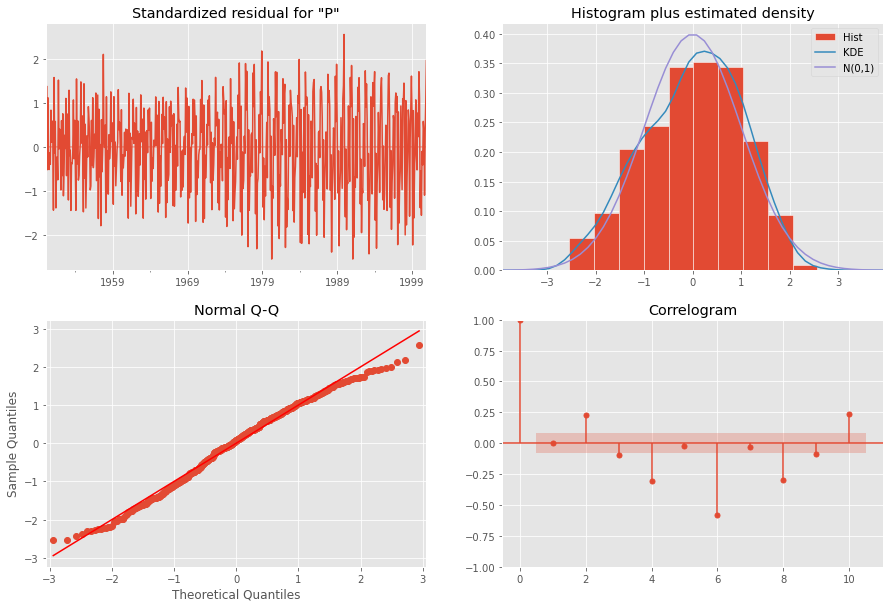

In [64]:

model_log.plot_diagnostics(figsize=(15,10))
plt.show()

The residuals plots looks significantly different than the previous models:
<ul>
<li><b>Standardized residual for parameter P:</b>these residuals look like gaussian white noise </li>
<li><b>Histogram and estimated density:</b>the distribution of the residuals are a little negative skewed.</li>
<li><b>Q-Qplot:</b>Shows a normal distribution because the plot looks straight and aligned to the line. Additionally the tails look more centered</li>
<li><b>Correlogram:</b>Most points shows correlation</li>
</ul>
The use of these residuals plot can give a glimpse on how a model performed. Nonetheless, the error metrics indicate otherwise. In this case this model performed defficiently.

<h2 style="color:#943126" id='three'> Conclusions</h2>

So far, four types of ARIMA models have been applied to the time series. The model that performed better is the one generated through the grid search auto-arima with seasonal component. This is because the  error metrics were lower and the difference between the training and test data was closer. To sum up, ARIMA models can make good forecast for one year and later it starts to fade or drift. 
Now it's time to see a time series forecast performed by <a style="color:#4267B2;font-weight:bold" href='03_FbProphet.ipynb'>Facebook Prophet</a>

<h2 style="color:#943126" id='four'>Sources</h2>

<li><a href="http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html">Pmdarima Documentation</a></li>
<li><a href='https://jadsmkbdatalab.nl/forecasting-with-sarimax-models'>https://jadsmkbdatalab.nl/forecasting-with-sarimax-models/</a><p>2022 JADS MKB Datalab</p></li>

<li>Nielsen, Aileen.<i>Practical Time Series Analysis</i>, O'Reilly Media, Inc, October 2019</li>